<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:09:58] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


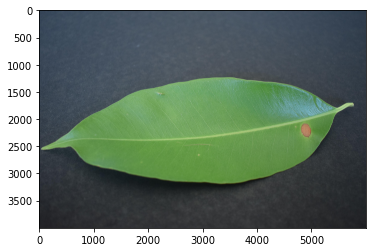

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

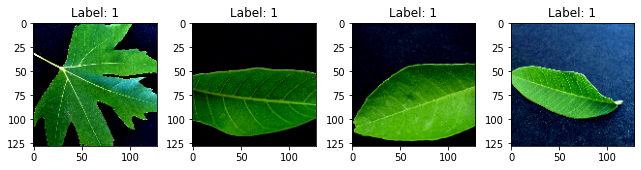

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:10:03] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:10:05] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2534509989674871 samples/sec                   batch loss = 1.0591590404510498 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2614607462710807 samples/sec                   batch loss = 0.7999927997589111 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.261475258162246 samples/sec                   batch loss = 0.5578068494796753 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2634182142844772 samples/sec                   batch loss = 1.1593202352523804 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.261846610556068 samples/sec                   batch loss = 0.2699529230594635 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2623729883799524 samples/sec                   batch loss = 0.6126006841659546 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2416115150677316 samples/sec                   batch loss = 0.7289291620254517 | accuracy = 0.5357142857142857


Epoch[1] Batch[40] Speed: 1.2618787844782107 samples/sec                   batch loss = 0.8619266748428345 | accuracy = 0.51875


Epoch[1] Batch[45] Speed: 1.2632882630533337 samples/sec                   batch loss = 0.6304419636726379 | accuracy = 0.5333333333333333


Epoch[1] Batch[50] Speed: 1.2628076948610554 samples/sec                   batch loss = 0.46299153566360474 | accuracy = 0.535


Epoch[1] Batch[55] Speed: 1.264369688888574 samples/sec                   batch loss = 0.48829391598701477 | accuracy = 0.5409090909090909


Epoch[1] Batch[60] Speed: 1.2611824291893559 samples/sec                   batch loss = 0.6608825325965881 | accuracy = 0.5333333333333333


Epoch[1] Batch[65] Speed: 1.2714444839026455 samples/sec                   batch loss = 0.664731502532959 | accuracy = 0.5346153846153846


Epoch[1] Batch[70] Speed: 1.266656962575023 samples/sec                   batch loss = 0.6166012287139893 | accuracy = 0.5464285714285714


Epoch[1] Batch[75] Speed: 1.2655518608585246 samples/sec                   batch loss = 0.45582500100135803 | accuracy = 0.55


Epoch[1] Batch[80] Speed: 1.2663274087102308 samples/sec                   batch loss = 0.26077648997306824 | accuracy = 0.56875


Epoch[1] Batch[85] Speed: 1.2653573349656486 samples/sec                   batch loss = 0.5430863499641418 | accuracy = 0.5764705882352941


Epoch[1] Batch[90] Speed: 1.2659960201286022 samples/sec                   batch loss = 0.4625003933906555 | accuracy = 0.5805555555555556


Epoch[1] Batch[95] Speed: 1.2692701968118933 samples/sec                   batch loss = 1.317817211151123 | accuracy = 0.5763157894736842


Epoch[1] Batch[100] Speed: 1.2731330348082095 samples/sec                   batch loss = 0.4028703272342682 | accuracy = 0.5825


Epoch[1] Batch[105] Speed: 1.2652760297948797 samples/sec                   batch loss = 0.6689997315406799 | accuracy = 0.5880952380952381


Epoch[1] Batch[110] Speed: 1.2702107945858538 samples/sec                   batch loss = 0.3733167052268982 | accuracy = 0.6022727272727273


Epoch[1] Batch[115] Speed: 1.2636121443787645 samples/sec                   batch loss = 0.600871741771698 | accuracy = 0.6043478260869565


Epoch[1] Batch[120] Speed: 1.2641560941794336 samples/sec                   batch loss = 0.7642879486083984 | accuracy = 0.6104166666666667


Epoch[1] Batch[125] Speed: 1.265076055903019 samples/sec                   batch loss = 0.7423474788665771 | accuracy = 0.616


Epoch[1] Batch[130] Speed: 1.271260472211454 samples/sec                   batch loss = 1.2034882307052612 | accuracy = 0.6096153846153847


Epoch[1] Batch[135] Speed: 1.2650005097033648 samples/sec                   batch loss = 0.533328652381897 | accuracy = 0.6129629629629629


Epoch[1] Batch[140] Speed: 1.2613923646633338 samples/sec                   batch loss = 0.5890154838562012 | accuracy = 0.6142857142857143


Epoch[1] Batch[145] Speed: 1.2625546260250269 samples/sec                   batch loss = 0.6432366371154785 | accuracy = 0.6137931034482759


Epoch[1] Batch[150] Speed: 1.2656477140555622 samples/sec                   batch loss = 0.6059055924415588 | accuracy = 0.615


Epoch[1] Batch[155] Speed: 1.2806327344962003 samples/sec                   batch loss = 0.5361620187759399 | accuracy = 0.6129032258064516


Epoch[1] Batch[160] Speed: 1.2703915204331861 samples/sec                   batch loss = 0.3819640576839447 | accuracy = 0.61875


Epoch[1] Batch[165] Speed: 1.270456840614355 samples/sec                   batch loss = 0.8081436157226562 | accuracy = 0.6181818181818182


Epoch[1] Batch[170] Speed: 1.2713542055426752 samples/sec                   batch loss = 0.3595781922340393 | accuracy = 0.6176470588235294


Epoch[1] Batch[175] Speed: 1.2622085905817295 samples/sec                   batch loss = 0.556067168712616 | accuracy = 0.6214285714285714


Epoch[1] Batch[180] Speed: 1.263750824719181 samples/sec                   batch loss = 0.709905207157135 | accuracy = 0.6222222222222222


Epoch[1] Batch[185] Speed: 1.269159776663435 samples/sec                   batch loss = 1.0512789487838745 | accuracy = 0.6189189189189189


Epoch[1] Batch[190] Speed: 1.262515482114494 samples/sec                   batch loss = 0.5261611938476562 | accuracy = 0.625


Epoch[1] Batch[195] Speed: 1.2623741282021976 samples/sec                   batch loss = 0.9374045729637146 | accuracy = 0.6256410256410256


Epoch[1] Batch[200] Speed: 1.2661224203946249 samples/sec                   batch loss = 0.7975676655769348 | accuracy = 0.625


Epoch[1] Batch[205] Speed: 1.2673168723502697 samples/sec                   batch loss = 0.6461631655693054 | accuracy = 0.6231707317073171


Epoch[1] Batch[210] Speed: 1.2693239735797592 samples/sec                   batch loss = 0.3292138874530792 | accuracy = 0.6297619047619047


Epoch[1] Batch[215] Speed: 1.2629610299823857 samples/sec                   batch loss = 0.4563441574573517 | accuracy = 0.6290697674418605


Epoch[1] Batch[220] Speed: 1.2702126217851872 samples/sec                   batch loss = 0.29713675379753113 | accuracy = 0.6363636363636364


Epoch[1] Batch[225] Speed: 1.2677408132478682 samples/sec                   batch loss = 0.6749661564826965 | accuracy = 0.6344444444444445


Epoch[1] Batch[230] Speed: 1.2662851632643002 samples/sec                   batch loss = 0.9019284248352051 | accuracy = 0.6347826086956522


Epoch[1] Batch[235] Speed: 1.2590459980758464 samples/sec                   batch loss = 0.7460123300552368 | accuracy = 0.6340425531914894


Epoch[1] Batch[240] Speed: 1.2599744313421908 samples/sec                   batch loss = 0.3444637358188629 | accuracy = 0.6364583333333333


Epoch[1] Batch[245] Speed: 1.2685471499983063 samples/sec                   batch loss = 0.7506011128425598 | accuracy = 0.636734693877551


Epoch[1] Batch[250] Speed: 1.2641679057392123 samples/sec                   batch loss = 0.5968202948570251 | accuracy = 0.64


Epoch[1] Batch[255] Speed: 1.263086634717368 samples/sec                   batch loss = 0.23496316373348236 | accuracy = 0.6431372549019608


Epoch[1] Batch[260] Speed: 1.266359238023409 samples/sec                   batch loss = 0.7257035970687866 | accuracy = 0.6432692307692308


Epoch[1] Batch[265] Speed: 1.266315843500261 samples/sec                   batch loss = 0.3818970322608948 | accuracy = 0.6443396226415095


Epoch[1] Batch[270] Speed: 1.2647208193192758 samples/sec                   batch loss = 0.6304717063903809 | accuracy = 0.6416666666666667


Epoch[1] Batch[275] Speed: 1.2647218680463619 samples/sec                   batch loss = 0.6994525194168091 | accuracy = 0.6409090909090909


Epoch[1] Batch[280] Speed: 1.2629220510035686 samples/sec                   batch loss = 0.30198341608047485 | accuracy = 0.6446428571428572


Epoch[1] Batch[285] Speed: 1.2624144982341323 samples/sec                   batch loss = 0.512107789516449 | accuracy = 0.6429824561403509


Epoch[1] Batch[290] Speed: 1.2706360005313624 samples/sec                   batch loss = 0.49765488505363464 | accuracy = 0.6413793103448275


Epoch[1] Batch[295] Speed: 1.2662632770263387 samples/sec                   batch loss = 0.6472971439361572 | accuracy = 0.6423728813559322


Epoch[1] Batch[300] Speed: 1.2696046470095017 samples/sec                   batch loss = 0.5137571096420288 | accuracy = 0.6425


Epoch[1] Batch[305] Speed: 1.2676237630495113 samples/sec                   batch loss = 0.48560255765914917 | accuracy = 0.6434426229508197


Epoch[1] Batch[310] Speed: 1.2650284569302075 samples/sec                   batch loss = 0.5696435570716858 | accuracy = 0.6451612903225806


Epoch[1] Batch[315] Speed: 1.2709040649847296 samples/sec                   batch loss = 0.7286295890808105 | accuracy = 0.6436507936507937


Epoch[1] Batch[320] Speed: 1.2700067583443753 samples/sec                   batch loss = 0.5640889406204224 | accuracy = 0.64765625


Epoch[1] Batch[325] Speed: 1.268450089925202 samples/sec                   batch loss = 0.5610384345054626 | accuracy = 0.65


Epoch[1] Batch[330] Speed: 1.268363112934423 samples/sec                   batch loss = 0.6151760220527649 | accuracy = 0.6522727272727272


Epoch[1] Batch[335] Speed: 1.2674527285578345 samples/sec                   batch loss = 0.4517936110496521 | accuracy = 0.6529850746268657


Epoch[1] Batch[340] Speed: 1.2595270164203363 samples/sec                   batch loss = 0.6280109882354736 | accuracy = 0.6544117647058824


Epoch[1] Batch[345] Speed: 1.2621763048840637 samples/sec                   batch loss = 0.7474183440208435 | accuracy = 0.6528985507246376


Epoch[1] Batch[350] Speed: 1.2676950250808006 samples/sec                   batch loss = 0.5690395832061768 | accuracy = 0.6557142857142857


Epoch[1] Batch[355] Speed: 1.2647269210285188 samples/sec                   batch loss = 0.9673293828964233 | accuracy = 0.6563380281690141


Epoch[1] Batch[360] Speed: 1.267325105230744 samples/sec                   batch loss = 0.26451951265335083 | accuracy = 0.6569444444444444


Epoch[1] Batch[365] Speed: 1.268244222124707 samples/sec                   batch loss = 0.5329701900482178 | accuracy = 0.6554794520547945


Epoch[1] Batch[370] Speed: 1.2696057999283819 samples/sec                   batch loss = 0.5280067324638367 | accuracy = 0.6554054054054054


Epoch[1] Batch[375] Speed: 1.2659779650079352 samples/sec                   batch loss = 0.452329158782959 | accuracy = 0.6546666666666666


Epoch[1] Batch[380] Speed: 1.2658407056143013 samples/sec                   batch loss = 0.37281548976898193 | accuracy = 0.6552631578947369


Epoch[1] Batch[385] Speed: 1.2659709914748587 samples/sec                   batch loss = 0.37946540117263794 | accuracy = 0.6545454545454545


Epoch[1] Batch[390] Speed: 1.2619397201188074 samples/sec                   batch loss = 0.6615193486213684 | accuracy = 0.6564102564102564


Epoch[1] Batch[395] Speed: 1.264835522233814 samples/sec                   batch loss = 0.3852003812789917 | accuracy = 0.6582278481012658


Epoch[1] Batch[400] Speed: 1.2647183405167133 samples/sec                   batch loss = 0.6857430934906006 | accuracy = 0.65875


Epoch[1] Batch[405] Speed: 1.264074752818439 samples/sec                   batch loss = 0.5512786507606506 | accuracy = 0.6592592592592592


Epoch[1] Batch[410] Speed: 1.2716908153679094 samples/sec                   batch loss = 0.6511251926422119 | accuracy = 0.6597560975609756


Epoch[1] Batch[415] Speed: 1.2650147216200425 samples/sec                   batch loss = 0.37649330496788025 | accuracy = 0.6614457831325301


Epoch[1] Batch[420] Speed: 1.267632957700123 samples/sec                   batch loss = 0.5527821183204651 | accuracy = 0.6625


Epoch[1] Batch[425] Speed: 1.2710795953629261 samples/sec                   batch loss = 0.49780017137527466 | accuracy = 0.6641176470588235


Epoch[1] Batch[430] Speed: 1.2674330041439397 samples/sec                   batch loss = 0.3163991868495941 | accuracy = 0.6651162790697674


Epoch[1] Batch[435] Speed: 1.2682438386420312 samples/sec                   batch loss = 0.44973328709602356 | accuracy = 0.6672413793103448


Epoch[1] Batch[440] Speed: 1.2656445632714932 samples/sec                   batch loss = 0.5402938723564148 | accuracy = 0.6681818181818182


Epoch[1] Batch[445] Speed: 1.2657841676031478 samples/sec                   batch loss = 0.7581090927124023 | accuracy = 0.6679775280898876


Epoch[1] Batch[450] Speed: 1.2676753889095964 samples/sec                   batch loss = 0.16316452622413635 | accuracy = 0.6711111111111111


Epoch[1] Batch[455] Speed: 1.265060507147232 samples/sec                   batch loss = 0.5347579121589661 | accuracy = 0.671978021978022


Epoch[1] Batch[460] Speed: 1.267866316602933 samples/sec                   batch loss = 0.16104748845100403 | accuracy = 0.6728260869565217


Epoch[1] Batch[465] Speed: 1.2656891530998686 samples/sec                   batch loss = 0.6756249070167542 | accuracy = 0.6725806451612903


Epoch[1] Batch[470] Speed: 1.2615693564334585 samples/sec                   batch loss = 0.5521263480186462 | accuracy = 0.6728723404255319


Epoch[1] Batch[475] Speed: 1.2633729280973323 samples/sec                   batch loss = 0.8532796502113342 | accuracy = 0.6736842105263158


Epoch[1] Batch[480] Speed: 1.2629590334396412 samples/sec                   batch loss = 0.7317120432853699 | accuracy = 0.6739583333333333


Epoch[1] Batch[485] Speed: 1.2646493193014872 samples/sec                   batch loss = 0.37759292125701904 | accuracy = 0.6726804123711341


Epoch[1] Batch[490] Speed: 1.2627195891671992 samples/sec                   batch loss = 1.4418185949325562 | accuracy = 0.673469387755102


Epoch[1] Batch[495] Speed: 1.2683588938468262 samples/sec                   batch loss = 0.8610255718231201 | accuracy = 0.6732323232323232


Epoch[1] Batch[500] Speed: 1.2652516021135471 samples/sec                   batch loss = 0.4561663568019867 | accuracy = 0.674


Epoch[1] Batch[505] Speed: 1.2686835579306106 samples/sec                   batch loss = 0.2812262773513794 | accuracy = 0.6747524752475248


Epoch[1] Batch[510] Speed: 1.2656079962281943 samples/sec                   batch loss = 0.6832812428474426 | accuracy = 0.6740196078431373


Epoch[1] Batch[515] Speed: 1.2670813232638785 samples/sec                   batch loss = 0.24315500259399414 | accuracy = 0.675242718446602


Epoch[1] Batch[520] Speed: 1.2644913805864295 samples/sec                   batch loss = 0.7436633706092834 | accuracy = 0.675


Epoch[1] Batch[525] Speed: 1.2632700948430526 samples/sec                   batch loss = 0.3517199456691742 | accuracy = 0.6761904761904762


Epoch[1] Batch[530] Speed: 1.2609331386353972 samples/sec                   batch loss = 0.5483733415603638 | accuracy = 0.6754716981132075


Epoch[1] Batch[535] Speed: 1.2653917878435104 samples/sec                   batch loss = 0.35268864035606384 | accuracy = 0.6780373831775701


Epoch[1] Batch[540] Speed: 1.265201032177184 samples/sec                   batch loss = 0.572354793548584 | accuracy = 0.6796296296296296


Epoch[1] Batch[545] Speed: 1.268705336033195 samples/sec                   batch loss = 0.5111067891120911 | accuracy = 0.6811926605504587


Epoch[1] Batch[550] Speed: 1.2663144098112629 samples/sec                   batch loss = 0.5832033753395081 | accuracy = 0.6804545454545454


Epoch[1] Batch[555] Speed: 1.27095384020535 samples/sec                   batch loss = 0.7600928544998169 | accuracy = 0.6801801801801802


Epoch[1] Batch[560] Speed: 1.2641339004746035 samples/sec                   batch loss = 0.7148616909980774 | accuracy = 0.6803571428571429


Epoch[1] Batch[565] Speed: 1.2684255395332085 samples/sec                   batch loss = 0.8540499210357666 | accuracy = 0.6792035398230089


Epoch[1] Batch[570] Speed: 1.2694037828608256 samples/sec                   batch loss = 0.42618778347969055 | accuracy = 0.6780701754385965


Epoch[1] Batch[575] Speed: 1.2692958362382056 samples/sec                   batch loss = 0.5041611194610596 | accuracy = 0.678695652173913


Epoch[1] Batch[580] Speed: 1.2617354855283953 samples/sec                   batch loss = 0.1975705325603485 | accuracy = 0.680603448275862


Epoch[1] Batch[585] Speed: 1.2650277892346216 samples/sec                   batch loss = 0.4796593189239502 | accuracy = 0.6811965811965812


Epoch[1] Batch[590] Speed: 1.2628388722046398 samples/sec                   batch loss = 0.7173553705215454 | accuracy = 0.6809322033898305


Epoch[1] Batch[595] Speed: 1.2646070904220494 samples/sec                   batch loss = 0.37408435344696045 | accuracy = 0.6815126050420168


Epoch[1] Batch[600] Speed: 1.2654067720904807 samples/sec                   batch loss = 0.20956894755363464 | accuracy = 0.68125


Epoch[1] Batch[605] Speed: 1.2661473594824326 samples/sec                   batch loss = 0.25648975372314453 | accuracy = 0.6801652892561983


Epoch[1] Batch[610] Speed: 1.2658706957309915 samples/sec                   batch loss = 0.5148599147796631 | accuracy = 0.6807377049180328


Epoch[1] Batch[615] Speed: 1.2697989433943528 samples/sec                   batch loss = 0.6242626905441284 | accuracy = 0.6804878048780488


Epoch[1] Batch[620] Speed: 1.2636271816814453 samples/sec                   batch loss = 0.9104704856872559 | accuracy = 0.6814516129032258


Epoch[1] Batch[625] Speed: 1.2684770389105255 samples/sec                   batch loss = 0.42125797271728516 | accuracy = 0.6812


Epoch[1] Batch[630] Speed: 1.26180029817423 samples/sec                   batch loss = 0.4253096878528595 | accuracy = 0.6817460317460318


Epoch[1] Batch[635] Speed: 1.2639032463897821 samples/sec                   batch loss = 0.5215278267860413 | accuracy = 0.6826771653543308


Epoch[1] Batch[640] Speed: 1.2670246743780202 samples/sec                   batch loss = 0.6240590214729309 | accuracy = 0.6828125


Epoch[1] Batch[645] Speed: 1.2652092375902195 samples/sec                   batch loss = 0.7219204306602478 | accuracy = 0.6833333333333333


Epoch[1] Batch[650] Speed: 1.2635419115907107 samples/sec                   batch loss = 0.22742930054664612 | accuracy = 0.6838461538461539


Epoch[1] Batch[655] Speed: 1.2658502564526635 samples/sec                   batch loss = 0.30133354663848877 | accuracy = 0.6854961832061068


Epoch[1] Batch[660] Speed: 1.264582783880934 samples/sec                   batch loss = 0.6377285122871399 | accuracy = 0.6867424242424243


Epoch[1] Batch[665] Speed: 1.264946431033938 samples/sec                   batch loss = 0.3450176417827606 | accuracy = 0.687218045112782


Epoch[1] Batch[670] Speed: 1.2646750583765496 samples/sec                   batch loss = 0.79962158203125 | accuracy = 0.6869402985074626


Epoch[1] Batch[675] Speed: 1.2668864226063332 samples/sec                   batch loss = 0.4358435869216919 | accuracy = 0.6862962962962963


Epoch[1] Batch[680] Speed: 1.2636821946104275 samples/sec                   batch loss = 0.5444584488868713 | accuracy = 0.6875


Epoch[1] Batch[685] Speed: 1.263936477481435 samples/sec                   batch loss = 0.5161197185516357 | accuracy = 0.6883211678832116


Epoch[1] Batch[690] Speed: 1.2624640856655547 samples/sec                   batch loss = 0.24556945264339447 | accuracy = 0.6876811594202898


Epoch[1] Batch[695] Speed: 1.2661529016353668 samples/sec                   batch loss = 1.1190223693847656 | accuracy = 0.6870503597122302


Epoch[1] Batch[700] Speed: 1.2666406099063656 samples/sec                   batch loss = 0.5821412801742554 | accuracy = 0.6875


Epoch[1] Batch[705] Speed: 1.265417843481813 samples/sec                   batch loss = 0.8139133453369141 | accuracy = 0.6872340425531915


Epoch[1] Batch[710] Speed: 1.267204686081782 samples/sec                   batch loss = 0.5132717490196228 | accuracy = 0.6873239436619718


Epoch[1] Batch[715] Speed: 1.2719510319183045 samples/sec                   batch loss = 0.23339389264583588 | accuracy = 0.6881118881118881


Epoch[1] Batch[720] Speed: 1.2683071164214137 samples/sec                   batch loss = 0.9293150901794434 | accuracy = 0.6885416666666667


Epoch[1] Batch[725] Speed: 1.2647843181127192 samples/sec                   batch loss = 0.44386348128318787 | accuracy = 0.6893103448275862


Epoch[1] Batch[730] Speed: 1.2701889647688172 samples/sec                   batch loss = 0.21564382314682007 | accuracy = 0.6904109589041096


Epoch[1] Batch[735] Speed: 1.2639020085891797 samples/sec                   batch loss = 0.4230555593967438 | accuracy = 0.691156462585034


Epoch[1] Batch[740] Speed: 1.264950627449505 samples/sec                   batch loss = 0.5295194387435913 | accuracy = 0.691554054054054


Epoch[1] Batch[745] Speed: 1.2669206717908192 samples/sec                   batch loss = 0.5318897366523743 | accuracy = 0.6916107382550336


Epoch[1] Batch[750] Speed: 1.2629191989776336 samples/sec                   batch loss = 0.6717379689216614 | accuracy = 0.6916666666666667


Epoch[1] Batch[755] Speed: 1.2629533290665829 samples/sec                   batch loss = 0.3132302165031433 | accuracy = 0.6913907284768211


Epoch[1] Batch[760] Speed: 1.2612933619925488 samples/sec                   batch loss = 0.25058290362358093 | accuracy = 0.6924342105263158


Epoch[1] Batch[765] Speed: 1.2657521762026265 samples/sec                   batch loss = 0.4142395853996277 | accuracy = 0.6924836601307189


Epoch[1] Batch[770] Speed: 1.2646073763869177 samples/sec                   batch loss = 0.3872903287410736 | accuracy = 0.6922077922077922


Epoch[1] Batch[775] Speed: 1.267645600562511 samples/sec                   batch loss = 0.31542667746543884 | accuracy = 0.6932258064516129


Epoch[1] Batch[780] Speed: 1.2748958257026997 samples/sec                   batch loss = 0.38076698780059814 | accuracy = 0.6939102564102564


Epoch[1] Batch[785] Speed: 1.2659989815996733 samples/sec                   batch loss = 0.9272187948226929 | accuracy = 0.6942675159235668


[Epoch 1] training: accuracy=0.694479695431472
[Epoch 1] time cost: 647.65651679039
[Epoch 1] validation: validation accuracy=0.7666666666666667


Epoch[2] Batch[5] Speed: 1.2631246728732166 samples/sec                   batch loss = 0.6325492858886719 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2758497310651076 samples/sec                   batch loss = 0.42960771918296814 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.270386806865528 samples/sec                   batch loss = 0.5095669031143188 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2689013726073308 samples/sec                   batch loss = 0.5006213784217834 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2733125638137532 samples/sec                   batch loss = 0.4028305113315582 | accuracy = 0.69


Epoch[2] Batch[30] Speed: 1.274292361757351 samples/sec                   batch loss = 0.2187502384185791 | accuracy = 0.6916666666666667


Epoch[2] Batch[35] Speed: 1.2693045750059542 samples/sec                   batch loss = 0.2379123866558075 | accuracy = 0.6857142857142857


Epoch[2] Batch[40] Speed: 1.2671960719164732 samples/sec                   batch loss = 0.49324527382850647 | accuracy = 0.6875


Epoch[2] Batch[45] Speed: 1.2701394417545186 samples/sec                   batch loss = 0.39559391140937805 | accuracy = 0.6944444444444444


Epoch[2] Batch[50] Speed: 1.2706547661739802 samples/sec                   batch loss = 1.012001633644104 | accuracy = 0.705


Epoch[2] Batch[55] Speed: 1.2743725066615623 samples/sec                   batch loss = 1.071209192276001 | accuracy = 0.7136363636363636


Epoch[2] Batch[60] Speed: 1.2695568987917307 samples/sec                   batch loss = 0.5520361065864563 | accuracy = 0.7125


Epoch[2] Batch[65] Speed: 1.272498615226539 samples/sec                   batch loss = 0.44319838285446167 | accuracy = 0.7153846153846154


Epoch[2] Batch[70] Speed: 1.2724865509679784 samples/sec                   batch loss = 0.30607137084007263 | accuracy = 0.725


Epoch[2] Batch[75] Speed: 1.2692777829012925 samples/sec                   batch loss = 0.35339292883872986 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2681188356495459 samples/sec                   batch loss = 0.5294402241706848 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2676979945059823 samples/sec                   batch loss = 0.40977171063423157 | accuracy = 0.7323529411764705


Epoch[2] Batch[90] Speed: 1.2735249139924405 samples/sec                   batch loss = 0.1177234873175621 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.272061263173857 samples/sec                   batch loss = 1.590175986289978 | accuracy = 0.7342105263157894


Epoch[2] Batch[100] Speed: 1.272487516100245 samples/sec                   batch loss = 0.4970472455024719 | accuracy = 0.7275


Epoch[2] Batch[105] Speed: 1.269568811491701 samples/sec                   batch loss = 0.6523324251174927 | accuracy = 0.7309523809523809


Epoch[2] Batch[110] Speed: 1.277406048630497 samples/sec                   batch loss = 0.1285592019557953 | accuracy = 0.7363636363636363


Epoch[2] Batch[115] Speed: 1.265285285842419 samples/sec                   batch loss = 0.48466670513153076 | accuracy = 0.7391304347826086


Epoch[2] Batch[120] Speed: 1.2673352528817587 samples/sec                   batch loss = 0.5454822778701782 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.2681614911095291 samples/sec                   batch loss = 0.30968454480171204 | accuracy = 0.746


Epoch[2] Batch[130] Speed: 1.2711407487079454 samples/sec                   batch loss = 0.6918008923530579 | accuracy = 0.7442307692307693


Epoch[2] Batch[135] Speed: 1.2697228320879963 samples/sec                   batch loss = 0.45284196734428406 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.2660223872617316 samples/sec                   batch loss = 0.8042647242546082 | accuracy = 0.7392857142857143


Epoch[2] Batch[145] Speed: 1.2637500631791572 samples/sec                   batch loss = 0.30168962478637695 | accuracy = 0.7448275862068966


Epoch[2] Batch[150] Speed: 1.2651210826769397 samples/sec                   batch loss = 0.23886136710643768 | accuracy = 0.745


Epoch[2] Batch[155] Speed: 1.2714476636303733 samples/sec                   batch loss = 0.9391468167304993 | accuracy = 0.7435483870967742


Epoch[2] Batch[160] Speed: 1.271291201349035 samples/sec                   batch loss = 0.8288361430168152 | accuracy = 0.740625


Epoch[2] Batch[165] Speed: 1.2671818109446784 samples/sec                   batch loss = 0.4737550914287567 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.269839213041339 samples/sec                   batch loss = 0.12058329582214355 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.272624579748015 samples/sec                   batch loss = 0.38082751631736755 | accuracy = 0.7371428571428571


Epoch[2] Batch[180] Speed: 1.2661046483108886 samples/sec                   batch loss = 0.9703688025474548 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.2753604327275607 samples/sec                   batch loss = 0.6619776487350464 | accuracy = 0.7337837837837838


Epoch[2] Batch[190] Speed: 1.2718511362782658 samples/sec                   batch loss = 1.203758716583252 | accuracy = 0.7302631578947368


Epoch[2] Batch[195] Speed: 1.2723923611026844 samples/sec                   batch loss = 0.24540778994560242 | accuracy = 0.7346153846153847


Epoch[2] Batch[200] Speed: 1.2675145867692732 samples/sec                   batch loss = 0.40426018834114075 | accuracy = 0.735


Epoch[2] Batch[205] Speed: 1.2705659470293587 samples/sec                   batch loss = 0.14049366116523743 | accuracy = 0.7378048780487805


Epoch[2] Batch[210] Speed: 1.2692613624929585 samples/sec                   batch loss = 0.6690785884857178 | accuracy = 0.736904761904762


Epoch[2] Batch[215] Speed: 1.2621549402569883 samples/sec                   batch loss = 0.5130484700202942 | accuracy = 0.736046511627907


Epoch[2] Batch[220] Speed: 1.2638240320386604 samples/sec                   batch loss = 0.6657858490943909 | accuracy = 0.7363636363636363


Epoch[2] Batch[225] Speed: 1.2622389786295618 samples/sec                   batch loss = 0.15130369365215302 | accuracy = 0.7388888888888889


Epoch[2] Batch[230] Speed: 1.2621531361660407 samples/sec                   batch loss = 0.3491048812866211 | accuracy = 0.741304347826087


Epoch[2] Batch[235] Speed: 1.2680504011989675 samples/sec                   batch loss = 0.3516589403152466 | accuracy = 0.7372340425531915


Epoch[2] Batch[240] Speed: 1.2681204651312556 samples/sec                   batch loss = 0.3779109716415405 | accuracy = 0.7375


Epoch[2] Batch[245] Speed: 1.274119619890895 samples/sec                   batch loss = 0.31313925981521606 | accuracy = 0.736734693877551


Epoch[2] Batch[250] Speed: 1.2706112692233618 samples/sec                   batch loss = 0.6981968879699707 | accuracy = 0.735


Epoch[2] Batch[255] Speed: 1.2769642482014498 samples/sec                   batch loss = 0.1554049253463745 | accuracy = 0.7362745098039216


Epoch[2] Batch[260] Speed: 1.2731345805900054 samples/sec                   batch loss = 0.6852719187736511 | accuracy = 0.7403846153846154


Epoch[2] Batch[265] Speed: 1.2713626836478584 samples/sec                   batch loss = 1.4934062957763672 | accuracy = 0.7396226415094339


Epoch[2] Batch[270] Speed: 1.2734256408925204 samples/sec                   batch loss = 0.4340461492538452 | accuracy = 0.7388888888888889


Epoch[2] Batch[275] Speed: 1.2745796911632203 samples/sec                   batch loss = 0.5729047060012817 | accuracy = 0.7390909090909091


Epoch[2] Batch[280] Speed: 1.2705171643318618 samples/sec                   batch loss = 0.46833711862564087 | accuracy = 0.7392857142857143


Epoch[2] Batch[285] Speed: 1.2694965701636205 samples/sec                   batch loss = 0.3388501703739166 | accuracy = 0.7394736842105263


Epoch[2] Batch[290] Speed: 1.281117282994225 samples/sec                   batch loss = 0.3751717507839203 | accuracy = 0.7405172413793103


Epoch[2] Batch[295] Speed: 1.272073512270533 samples/sec                   batch loss = 0.8587342500686646 | accuracy = 0.738135593220339


Epoch[2] Batch[300] Speed: 1.2715923098798048 samples/sec                   batch loss = 0.487714022397995 | accuracy = 0.7383333333333333


Epoch[2] Batch[305] Speed: 1.2684676402019754 samples/sec                   batch loss = 0.17251986265182495 | accuracy = 0.739344262295082


Epoch[2] Batch[310] Speed: 1.2740120307043805 samples/sec                   batch loss = 0.21136020123958588 | accuracy = 0.7387096774193549


Epoch[2] Batch[315] Speed: 1.2738225360351154 samples/sec                   batch loss = 0.9848456382751465 | accuracy = 0.7404761904761905


Epoch[2] Batch[320] Speed: 1.2697953874862016 samples/sec                   batch loss = 0.2658259868621826 | accuracy = 0.74375


Epoch[2] Batch[325] Speed: 1.2732454036030476 samples/sec                   batch loss = 0.5909172296524048 | accuracy = 0.7446153846153846


Epoch[2] Batch[330] Speed: 1.2687058157355005 samples/sec                   batch loss = 0.5651200413703918 | accuracy = 0.7454545454545455


Epoch[2] Batch[335] Speed: 1.2701743478658174 samples/sec                   batch loss = 0.3066807687282562 | accuracy = 0.746268656716418


Epoch[2] Batch[340] Speed: 1.2722128985272942 samples/sec                   batch loss = 0.2682551145553589 | accuracy = 0.7448529411764706


Epoch[2] Batch[345] Speed: 1.2704538582506157 samples/sec                   batch loss = 0.9080327153205872 | accuracy = 0.7456521739130435


Epoch[2] Batch[350] Speed: 1.2743219793519507 samples/sec                   batch loss = 0.649034321308136 | accuracy = 0.7464285714285714


Epoch[2] Batch[355] Speed: 1.267505010799756 samples/sec                   batch loss = 0.43800216913223267 | accuracy = 0.7471830985915493


Epoch[2] Batch[360] Speed: 1.270980991969067 samples/sec                   batch loss = 0.6177988052368164 | accuracy = 0.7472222222222222


Epoch[2] Batch[365] Speed: 1.2679673121524981 samples/sec                   batch loss = 0.5344920754432678 | accuracy = 0.75


Epoch[2] Batch[370] Speed: 1.2723249119709164 samples/sec                   batch loss = 0.956116259098053 | accuracy = 0.75


Epoch[2] Batch[375] Speed: 1.2708967482597073 samples/sec                   batch loss = 0.18098849058151245 | accuracy = 0.7506666666666667


Epoch[2] Batch[380] Speed: 1.269632798044108 samples/sec                   batch loss = 0.6274135708808899 | accuracy = 0.75


Epoch[2] Batch[385] Speed: 1.2736978814160556 samples/sec                   batch loss = 0.4003128111362457 | accuracy = 0.75


Epoch[2] Batch[390] Speed: 1.268904539627741 samples/sec                   batch loss = 0.22317101061344147 | accuracy = 0.7506410256410256


Epoch[2] Batch[395] Speed: 1.269763385209025 samples/sec                   batch loss = 0.2519887089729309 | accuracy = 0.7525316455696203


Epoch[2] Batch[400] Speed: 1.2715411354594128 samples/sec                   batch loss = 0.5379654765129089 | accuracy = 0.751875


Epoch[2] Batch[405] Speed: 1.2723458503494223 samples/sec                   batch loss = 0.45503103733062744 | accuracy = 0.7530864197530864


Epoch[2] Batch[410] Speed: 1.2703849791650308 samples/sec                   batch loss = 0.8213739991188049 | accuracy = 0.7518292682926829


Epoch[2] Batch[415] Speed: 1.2740985263342075 samples/sec                   batch loss = 0.21043364703655243 | accuracy = 0.7542168674698795


Epoch[2] Batch[420] Speed: 1.2779972790442224 samples/sec                   batch loss = 0.6078107953071594 | accuracy = 0.7523809523809524


Epoch[2] Batch[425] Speed: 1.2717172274571562 samples/sec                   batch loss = 0.35048380494117737 | accuracy = 0.7523529411764706


Epoch[2] Batch[430] Speed: 1.2724549919495145 samples/sec                   batch loss = 0.1400408297777176 | accuracy = 0.7534883720930232


Epoch[2] Batch[435] Speed: 1.275369546054258 samples/sec                   batch loss = 0.5321344137191772 | accuracy = 0.7540229885057471


Epoch[2] Batch[440] Speed: 1.2724373311636117 samples/sec                   batch loss = 0.9825079441070557 | accuracy = 0.7528409090909091


Epoch[2] Batch[445] Speed: 1.2767710565960657 samples/sec                   batch loss = 0.15400131046772003 | accuracy = 0.7522471910112359


Epoch[2] Batch[450] Speed: 1.26522917909576 samples/sec                   batch loss = 0.7453703880310059 | accuracy = 0.7527777777777778


Epoch[2] Batch[455] Speed: 1.2580296870787986 samples/sec                   batch loss = 0.669590950012207 | accuracy = 0.7510989010989011


Epoch[2] Batch[460] Speed: 1.266178224158282 samples/sec                   batch loss = 0.3982255458831787 | accuracy = 0.7516304347826087


Epoch[2] Batch[465] Speed: 1.2721348577524048 samples/sec                   batch loss = 0.24761153757572174 | accuracy = 0.7521505376344086


Epoch[2] Batch[470] Speed: 1.2714648151632864 samples/sec                   batch loss = 0.3448675870895386 | accuracy = 0.7537234042553191


Epoch[2] Batch[475] Speed: 1.2699095709165764 samples/sec                   batch loss = 0.48442745208740234 | accuracy = 0.7536842105263157


Epoch[2] Batch[480] Speed: 1.270353909061186 samples/sec                   batch loss = 0.4149223268032074 | accuracy = 0.7526041666666666


Epoch[2] Batch[485] Speed: 1.2649732313486144 samples/sec                   batch loss = 0.4494918882846832 | accuracy = 0.7505154639175258


Epoch[2] Batch[490] Speed: 1.271859235340205 samples/sec                   batch loss = 0.1458033323287964 | accuracy = 0.7520408163265306


Epoch[2] Batch[495] Speed: 1.2727918953248545 samples/sec                   batch loss = 0.3782016932964325 | accuracy = 0.7525252525252525


Epoch[2] Batch[500] Speed: 1.2702633046197103 samples/sec                   batch loss = 0.6904657483100891 | accuracy = 0.752


Epoch[2] Batch[505] Speed: 1.2683139239526433 samples/sec                   batch loss = 0.7632416486740112 | accuracy = 0.7514851485148515


Epoch[2] Batch[510] Speed: 1.2643030876119035 samples/sec                   batch loss = 0.1943398118019104 | accuracy = 0.7514705882352941


Epoch[2] Batch[515] Speed: 1.2726565333349111 samples/sec                   batch loss = 1.350742220878601 | accuracy = 0.7504854368932039


Epoch[2] Batch[520] Speed: 1.2718439050601253 samples/sec                   batch loss = 0.5786105990409851 | accuracy = 0.7504807692307692


Epoch[2] Batch[525] Speed: 1.2645780180020467 samples/sec                   batch loss = 0.5570369362831116 | accuracy = 0.7504761904761905


Epoch[2] Batch[530] Speed: 1.2712181859524962 samples/sec                   batch loss = 0.4248195290565491 | accuracy = 0.75


Epoch[2] Batch[535] Speed: 1.2714317651507745 samples/sec                   batch loss = 0.20076115429401398 | accuracy = 0.7509345794392523


Epoch[2] Batch[540] Speed: 1.273468267464819 samples/sec                   batch loss = 0.613594114780426 | accuracy = 0.7509259259259259


Epoch[2] Batch[545] Speed: 1.2740045814063792 samples/sec                   batch loss = 1.394781470298767 | accuracy = 0.7490825688073395


Epoch[2] Batch[550] Speed: 1.2689201830210577 samples/sec                   batch loss = 0.4482278823852539 | accuracy = 0.7477272727272727


Epoch[2] Batch[555] Speed: 1.268656120504522 samples/sec                   batch loss = 0.49998319149017334 | accuracy = 0.7463963963963964


Epoch[2] Batch[560] Speed: 1.2698144166319705 samples/sec                   batch loss = 0.2453133761882782 | accuracy = 0.7473214285714286


Epoch[2] Batch[565] Speed: 1.2678416929931053 samples/sec                   batch loss = 0.4037413001060486 | accuracy = 0.7477876106194691


Epoch[2] Batch[570] Speed: 1.266796312089832 samples/sec                   batch loss = 0.31925255060195923 | accuracy = 0.7482456140350877


Epoch[2] Batch[575] Speed: 1.268238469908922 samples/sec                   batch loss = 0.2926303744316101 | accuracy = 0.7486956521739131


Epoch[2] Batch[580] Speed: 1.26357274453625 samples/sec                   batch loss = 0.2151467353105545 | accuracy = 0.7491379310344828


Epoch[2] Batch[585] Speed: 1.265341111268488 samples/sec                   batch loss = 0.28001776337623596 | accuracy = 0.7482905982905983


Epoch[2] Batch[590] Speed: 1.270625703721953 samples/sec                   batch loss = 0.509351372718811 | accuracy = 0.7487288135593221


Epoch[2] Batch[595] Speed: 1.2732592215998813 samples/sec                   batch loss = 0.5202585458755493 | accuracy = 0.7495798319327731


Epoch[2] Batch[600] Speed: 1.2693369383036952 samples/sec                   batch loss = 0.9131897687911987 | accuracy = 0.7495833333333334


Epoch[2] Batch[605] Speed: 1.2658658246281185 samples/sec                   batch loss = 0.5445233583450317 | accuracy = 0.75


Epoch[2] Batch[610] Speed: 1.2658375538692694 samples/sec                   batch loss = 0.3659442067146301 | accuracy = 0.75


Epoch[2] Batch[615] Speed: 1.2735005534346422 samples/sec                   batch loss = 0.38512253761291504 | accuracy = 0.7491869918699187


Epoch[2] Batch[620] Speed: 1.276679825956164 samples/sec                   batch loss = 0.6351979970932007 | accuracy = 0.7479838709677419


Epoch[2] Batch[625] Speed: 1.2713540128597807 samples/sec                   batch loss = 0.37452852725982666 | accuracy = 0.7488


Epoch[2] Batch[630] Speed: 1.2672378038523624 samples/sec                   batch loss = 0.42220112681388855 | accuracy = 0.7484126984126984


Epoch[2] Batch[635] Speed: 1.272619463461682 samples/sec                   batch loss = 0.5621364116668701 | accuracy = 0.7476377952755906


Epoch[2] Batch[640] Speed: 1.2677429207326685 samples/sec                   batch loss = 0.6336081027984619 | accuracy = 0.746484375


Epoch[2] Batch[645] Speed: 1.2723737370941275 samples/sec                   batch loss = 0.28898483514785767 | accuracy = 0.7468992248062015


Epoch[2] Batch[650] Speed: 1.2723247189936744 samples/sec                   batch loss = 0.9036021828651428 | accuracy = 0.7469230769230769


Epoch[2] Batch[655] Speed: 1.2710264400702498 samples/sec                   batch loss = 0.3672430217266083 | accuracy = 0.7461832061068703


Epoch[2] Batch[660] Speed: 1.262945818387312 samples/sec                   batch loss = 0.4201977550983429 | accuracy = 0.7462121212121212


Epoch[2] Batch[665] Speed: 1.2640738956467203 samples/sec                   batch loss = 0.6132597923278809 | accuracy = 0.7454887218045113


Epoch[2] Batch[670] Speed: 1.2802831680987792 samples/sec                   batch loss = 0.6495122313499451 | accuracy = 0.7458955223880597


Epoch[2] Batch[675] Speed: 1.2750468779081383 samples/sec                   batch loss = 0.36722874641418457 | accuracy = 0.747037037037037


Epoch[2] Batch[680] Speed: 1.2699140886967974 samples/sec                   batch loss = 0.2699451744556427 | accuracy = 0.7474264705882353


Epoch[2] Batch[685] Speed: 1.2776529443668774 samples/sec                   batch loss = 0.37294912338256836 | accuracy = 0.7478102189781022


Epoch[2] Batch[690] Speed: 1.2724967814444947 samples/sec                   batch loss = 0.4532206654548645 | accuracy = 0.7481884057971014


Epoch[2] Batch[695] Speed: 1.2722933609694815 samples/sec                   batch loss = 0.14777301251888275 | accuracy = 0.7482014388489209


Epoch[2] Batch[700] Speed: 1.270050983067517 samples/sec                   batch loss = 0.5108498334884644 | accuracy = 0.7482142857142857


Epoch[2] Batch[705] Speed: 1.2757262314739972 samples/sec                   batch loss = 0.6579777598381042 | accuracy = 0.7468085106382979


Epoch[2] Batch[710] Speed: 1.270293312302629 samples/sec                   batch loss = 0.522796630859375 | accuracy = 0.7468309859154929


Epoch[2] Batch[715] Speed: 1.2637879509083796 samples/sec                   batch loss = 0.3648150563240051 | accuracy = 0.7475524475524475


Epoch[2] Batch[720] Speed: 1.268191878884057 samples/sec                   batch loss = 0.5311880707740784 | accuracy = 0.7486111111111111


Epoch[2] Batch[725] Speed: 1.2671373072912289 samples/sec                   batch loss = 0.36911049485206604 | accuracy = 0.7482758620689656


Epoch[2] Batch[730] Speed: 1.273954276739369 samples/sec                   batch loss = 0.6626503467559814 | accuracy = 0.7479452054794521


Epoch[2] Batch[735] Speed: 1.2691055338022743 samples/sec                   batch loss = 0.7159209847450256 | accuracy = 0.748639455782313


Epoch[2] Batch[740] Speed: 1.2664895350449683 samples/sec                   batch loss = 0.5051248669624329 | accuracy = 0.7486486486486487


Epoch[2] Batch[745] Speed: 1.2676825728041046 samples/sec                   batch loss = 0.29968464374542236 | accuracy = 0.748993288590604


Epoch[2] Batch[750] Speed: 1.2673898232256828 samples/sec                   batch loss = 0.6707859635353088 | accuracy = 0.748


Epoch[2] Batch[755] Speed: 1.2673635905790706 samples/sec                   batch loss = 0.5329942107200623 | accuracy = 0.747682119205298


Epoch[2] Batch[760] Speed: 1.2754722254046742 samples/sec                   batch loss = 0.47517135739326477 | accuracy = 0.7483552631578947


Epoch[2] Batch[765] Speed: 1.2698751599433986 samples/sec                   batch loss = 0.11562749743461609 | accuracy = 0.7490196078431373


Epoch[2] Batch[770] Speed: 1.2703792075137756 samples/sec                   batch loss = 0.2822437584400177 | accuracy = 0.7496753246753247


Epoch[2] Batch[775] Speed: 1.2630415624685223 samples/sec                   batch loss = 0.6489017605781555 | accuracy = 0.7493548387096775


Epoch[2] Batch[780] Speed: 1.2620325586216619 samples/sec                   batch loss = 0.23472446203231812 | accuracy = 0.75


Epoch[2] Batch[785] Speed: 1.2643167121948962 samples/sec                   batch loss = 0.33514922857284546 | accuracy = 0.75


[Epoch 2] training: accuracy=0.7509517766497462
[Epoch 2] time cost: 638.4332482814789
[Epoch 2] validation: validation accuracy=0.8011111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7755555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)